In [8]:
! pip install --user requests
! pip install --user Pillow
! pip install --user beautifulsoup4

  Using cached beautifulsoup4-4.6.0-py2-none-any.whl


In [48]:
import utils
import pandas
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

In [2]:
posts, images = utils.getData()

In [10]:
print len(posts)
print images.shape
data = pandas.DataFrame(posts)

375
(650, 750, 750, 3)


In [11]:
hasImage = []
for i in range(images.shape[0]):
    if (images[i].mean() == 0.):
        hasImage += [False]
    else:
        hasImage += [True]
print len(hasImage)
images2 = []
images2 = images[hasImage]
print images2.shape, images.shape

650
(375, 750, 750, 3) (650, 750, 750, 3)


In [12]:
data

,caption,code,comments,date,height,id,imgurl,likes,userid,width
0,Bonne soirée IG ☁️\n#feelgood #beautifullife #...,BY6llaWnWXl,0,1505164444,1080,1601757916121884133,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,1384958716,1080
1,"It's been a while, Edinburgh! Climbing Arthur ...",BY6llYqliF2,0,1505164444,1080,1601757914309468534,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,1451073080,1080
2,#photography #sky #skyscape #skyscapes,BY6llXjnOMn,0,1505164444,1080,1601757913118728999,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,2028723972,1080
3,#WLOliveira📷📷📷\nEnsaio casal Douglas Rodrigues...,BY6llW-lIpT,0,1505164444,321,1601757912497424979,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,5386257875,480
4,#huracanirma #hurricaneirma2017 #hurricane #hu...,BY6llS7laeo,0,1505164443,1080,1601757908152199080,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,4837584944,1080
5,G e t a w a y 🌴☀️🌴\n.\n.\n.\n.\n.\n.\n.\n.\n.\...,BY6llNmHRiA,0,1505164443,1347,1601757902423267456,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,1,3268654758,1080
6,"@ustrichka_daria , твои волосы летят будто луч...",BY6llKCBXJb,0,1505164442,720,1601757898596512347,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,353722948,1080
7,#nature #974 #reunionisland #green #fujixt1 #p...,BY6llHVHRQl,0,1505164442,720,1601757895695602725,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,2205945003,1080
8,Getting direction 🗺📍🔝\n.\n.\n.\n#explore #expl...,BY6llF-BXf7,0,1505164442,1080,1601757894234437627,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,236562786,1080
9,Soy un Pug xd\n.\n.\n #picoftheday #picoftheni...,BY6llFjDoHb,0,1505164442,600,1601757893782045147,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,1,3200612520,480


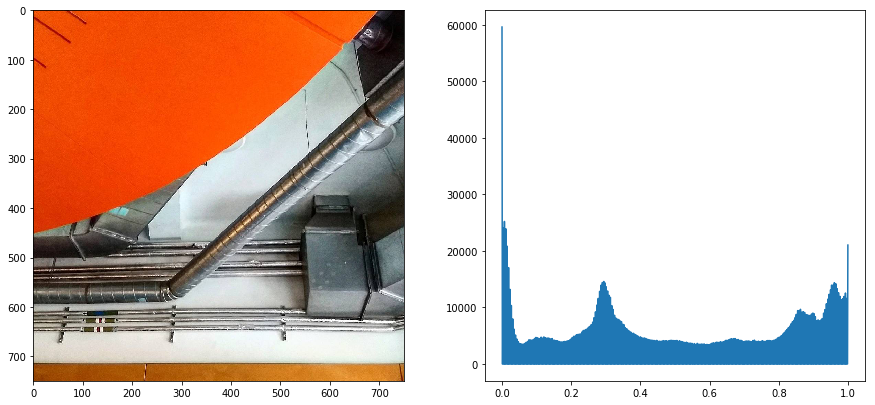

caption                             #waitingroom #photography
code                                              BY6llAqAfu7
comments                                                    0
date                                               1505164441
height                                                   1080
id                                        1601757888529955771
imgurl      https://instagram.fbed1-1.fna.fbcdn.net/t51.28...
likes                                                       0
userid                                             6001112324
width                                                    1080
Name: 11, dtype: object


In [13]:
index = 11

fig = plt.figure(figsize=[15,15])

ax1 = fig.add_subplot(221)
ax1.imshow(images2[index]/255.)

ax2 = fig.add_subplot(222)
hist,bins = np.histogram(images2[index]/255.,bins=1000)
ax2.plot(.5*(bins[1:]+bins[:-1]),hist)

plt.show()

print data.iloc[index]

In [14]:
foodposts, foodimages = utils.getData('posts_food_1505318769.json',rawimages=True)
print len(foodposts), foodimages.shape
data = pandas.DataFrame(foodposts)

326 (326, 300, 300, 3)


In [47]:
def getlist(x,args,y):
    list = x['caption'].split(' #')
    return (args in list[1:])

data.loc[data.apply(getlist,args=[u'fashion',0],axis=1)]

,caption,code,comments,date,height,id,imgurl,likes,userid,width
2,🖤 #mbfwi #fashionweek #fashion #love #photooft...,BY_L6rlgiEL,0,1505318759,1080,1603052403408642315,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,188317646,1080
17,#jazzybollywood #hairdresser #barber #smile #l...,BY_MJ4fAdsH,0,1505318884,800,1603053448050367239,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,2345368632,640
22,Wishing we were in Vegas rn 🤑#love #TagsForLik...,BY_MJqNjarJ,0,1505318882,1344,1603053432725154505,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,179943252,1080
43,Con ma Monkey bebé! .\n.\n.\n.\n.\n.\n.\n.\n#l...,BY_MYnvBKsD,0,1505319005,1316,1603054460857527043,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,1,191852720,1080
48,Because black ice cream is better. #black #bb ...,BY_MojJH1Xs,0,1505319135,937,1603055555438401004,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,4928647049,750
57,🍂Bavarian Soup 🍂#love #TagsForLikes #TagsForLi...,BY_MngyAuSO,0,1505319127,1350,1603055484183700622,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,1,42802365,1080
58,#love #TagsForLikes #TagsForLikesApp #instagoo...,BY_MneYgWqp,0,1505319126,1350,1603055481608301225,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,1,33791742,1080
73,FOLLOW @cakess.videos 🍰\nCredit @genc.sefff\n#...,BY_M27vgxYO,0,1505319253,1080,1603056543924950542,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,3,3572003971,1080
74,#love #TagsForLikes #TagsForLikesApp #instagoo...,BY_NG1blvOF,0,1505319383,810,1603057636659884933,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,181740321,1080
103,#Repost @optimareviews (@get_repost)\n・・・\nI a...,BY_NlMcjUTh,0,1505319632,750,1603059722956391649,https://instagram.fbed1-1.fna.fbcdn.net/t51.28...,0,1316937848,750


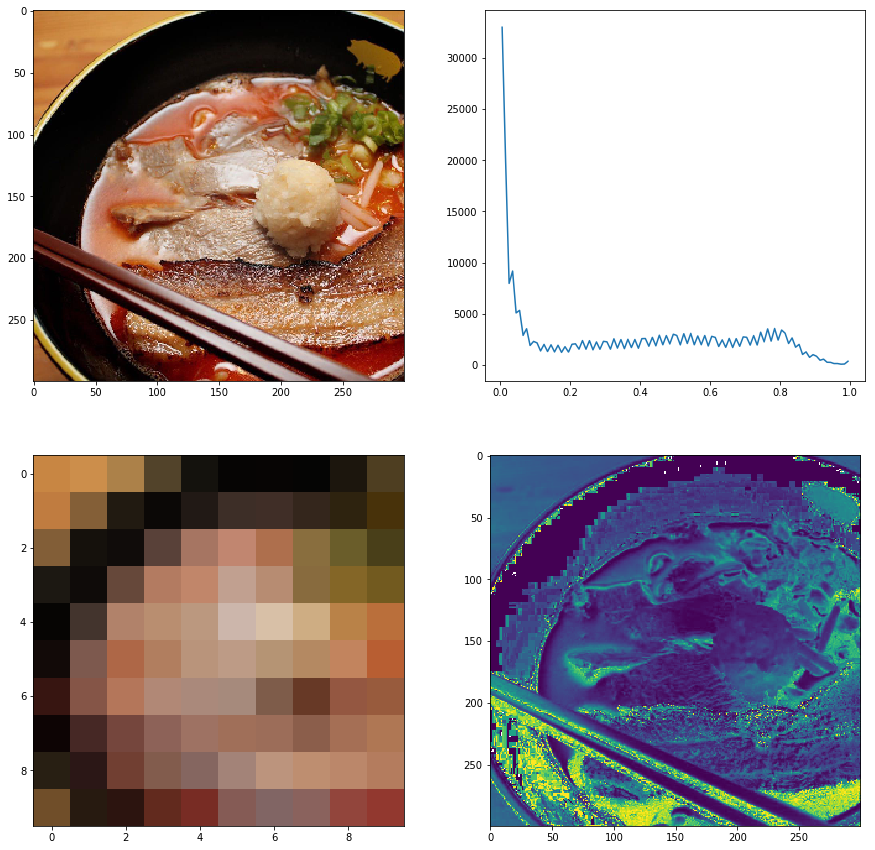

caption     For those who are wondering: Yes, that is inde...
code                                              BY_L6Vqg9u_
comments                                                    0
date                                               1505318757
height                                                   1077
id                                        1603052379870321599
imgurl      https://instagram.fbed1-1.fna.fbcdn.net/t51.28...
likes                                                       2
userid                                              193589582
width                                                    1080
Name: 6, dtype: object


In [72]:
from scipy.misc import imresize
import colorsys
import features

index = 6

fig = plt.figure(figsize=[15,15])

ax1 = fig.add_subplot(221)
ax1.imshow(foodimages[index]/255.)

ax2 = fig.add_subplot(222)
hist,bins = np.histogram(foodimages[index]/255.,bins=100)
ax2.plot(.5*(bins[1:]+bins[:-1]),hist)

ax3 = fig.add_subplot(223)
newimage = np.zeros([10,10,3])
for i in range(3):
    newimage[:,:,i] = imresize(foodimages[index,:,:,i],[10,10])
ax3.imshow(newimage/255.)

ax4 = fig.add_subplot(224)
rgb = foodimages[index]
saturation = features.saturation(rgb)
ax4.imshow(saturation/255.)

plt.show()

print data.iloc[index]

68.771650977424144